In [1]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
using DoubleFloats

Solving Stokes equations using Local Hermitian Interpolation with Div-free Polyharmonic kernel with polynomial reproductuion 
Key takeaways:
- It is not proven that div-free matrix kernel formed with polyharmonic RBF is conditionally positive definite, and if it is, which degree of conditionaly positive definitness it has 
- From numerical experiments it seems like it is indeed positive definite even without additional ponynomial basis, but it might be a lucky special case. I assume that matrix kernel formed by polyharmonics retains the same degree of c-pos-def as scalar polyharmonic function that creates it.
- Polynomial basis has to satisfy 2 properties: velocity subspace has to be div-free. pressure subspace can't contain constnt functions, otherwise matrices are degenerate. 
- Local stensil has to have enough points, such that it is m-unisolvent. Higher polynomial degree requires more points in the stencil, oterwise doesn't work. It is somewhat similar to a limit on the accuracy for a given stencil size in classical finite differences. 
- for the same separation distance, polyharmonic div-free kernel has considerably lower kondition number than anything else 
- If a true solution is a polynomial of a degree lower than the degree of the basis, the method recovers the solution with machine precision.

In [2]:
# create functionals
μ = 1.0
ρ = 1.0
@variables ϵ r x₁ x₂ ;
ϕ1 = r^7
ϕ2 = r^3

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]
#display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
#display(F_A)
F_A = compile_kernel_array(F_A)
F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
#display(F_B)
F_B = compile_kernel_array(F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)

F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
#display(F_PA)
F_PA = compile_polynomials(F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
display(F_PB)
F_PB = compile_polynomials(F_PB)

N_poly = size(F_PA)[2]

println("done")

2×25 Matrix{Num}:
 0.0  0.0  0.0  -2.0  0.0  -2.0  -6.0x₂  …  0.0  1.0    0.0  x₂  2x₁
 0.0  0.0  0.0   0.0  1.0   0.0   0.0       1.0  0.0  2x₂    x₁    0.0

done


In [3]:
# create true solution
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

#u = 20*x*y^3
#v = 5*x^4 - 5*y^4
#p = 60*x*x*y - 20*y*y*y 
display(dx(u)+dy(v))
f1 = -(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ
f2 = -(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
true_v1 = eval(build_function(u,x,y))
true_v2 = eval(build_function(v,x,y))
f1(12,2)
function gu(x,y)
    """
    if abs(y-1) < 1e-10 
        return 1#-(0.5-x)^2 + 0.25
    else
        return 0.0
    end
    """
    return true_v1(x,y)
end
gv(x,y) = true_v2(x,y)
gu(0.9,1)

0

8.0y*cos(x^2 + y^2) + cos(x - y) - 4.0(y^3)*sin(x^2 + y^2) - 4.0y*(x^2)*sin(x^2 + y^2)

4.0(x^3)*sin(x^2 + y^2) + 4.0x*(y^2)*sin(x^2 + y^2) - cos(x - y) - 8.0x*cos(x^2 + y^2)

-0.9715269558223153

2×76 Matrix{Float64}:
 0.0  0.0        0.0       0.0       …  1.0       1.0       1.0       1.0
 0.0  0.0526316  0.105263  0.157895     0.842105  0.894737  0.947368  1.0

[0.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[1.0, 1.0]

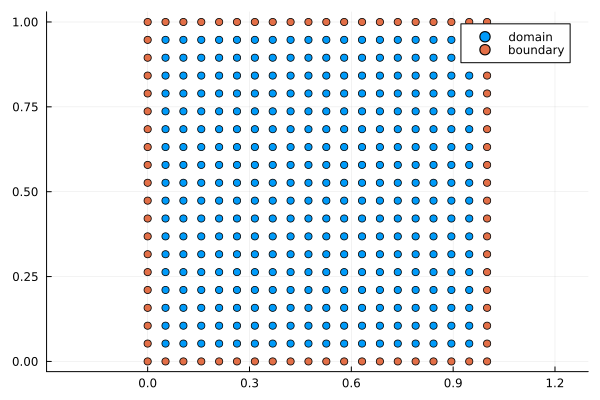

In [4]:
# create points 
N_side = 20
I_points, B_points = generate_2D_equally_spaced_points(N_side)
All_points = hcat(I_points, B_points)
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
#all_points = [domain_p boundary_p]
println(B_points[:,1])
println(B_points[:,N_side])
println(B_points[:,3*N_side-3])
println(B_points[:,4*N_side-4])
#B_points = B_points[:, setdiff(1:end,[1,N_side,4*N_side-4,3*N_side-3])]
display(B_points)
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [18]:
# assemble matrices and rhs 
k =35
param = 5
r = 2.01*1.45/(N_side-1)
I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
All_tree  = KDTree(All_points,Euclidean(),leafsize = 3)
neighbours,_ = knn(All_tree, I_points, k, true) 
G = zeros(2*N_I,2*N_I) # global sprse matrix 
#Global_RHS = zeros(2*N_I)
Global_RHS = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
cond_num_array = zeros(N_I)
for i in 1:N_I
    #I_idx = inrange(I_tree, I_points[:,i], r, true)
    #I_idx, _ = knn(I_tree, I_points[:,i], k, true)
    
    I_idx = neighbours[i][findall(x -> x<=N_I , neighbours[i])][2:end]
    #I_idx = deleteat!(I_idx,findall(x->x==i,I_idx))
    #println(neighbours[i][findall(x -> x<=N_I , neighbours[i])])
    B_idx = neighbours[i][findall(x -> x>N_I , neighbours[i])] .-N_I 
    #B_idx = inrange(B_tree, I_points[:,i], r, true)
    Local_B_points = B_points[:,B_idx] .- reshape(I_points[:,i],(2,1))
    Local_I_points = I_points[:,I_idx] .- reshape(I_points[:,i],(2,1))
    #println(I_idx)
    #display(Local_I_points)
    Full_Local_I_points = hcat(I_points[:,i],I_points[:,I_idx]) .- reshape(I_points[:,i],(2,1))# internal points including center 
    #println(Full_Local_I_points)
    default_point_list = [Full_Local_I_points,Full_Local_I_points,Local_I_points,Local_I_points] # list of points if no boundary is present
    sample_point_list = [reshape([0.0,0.0],(2,1)),reshape([0.0,0.0],(2,1))]
    #sample_point_list = [reshape(I_points[:,i],(2,1)),reshape(I_points[:,i],(2,1))]
    L_RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
    if isempty(B_idx)
        # No boundary points nearby
        #T = point_difference_tensor(Points,Points)
        PA = generate_P_matrix(default_point_list,F_PA[1:end-2,:])
        
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A[1:4,1:4],T,param))
        B = flatten(generate_block_matrices(F_B[:,1:4],T2,param))
        RHS = vcat(L_RHS,zeros(N_poly))
        #display(A)
        status = "interiror"
    else
        append!(default_point_list,[Local_B_points,Local_B_points])
        PA = generate_P_matrix(default_point_list,F_PA[1:end,:])
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A,T,param))
        B = flatten(generate_block_matrices(F_B,T2,param))
        
        #RHS = vcat(L_RHS,true_v1.(B_points[1,B_idx],B_points[2,B_idx]),true_v2.(B_points[1,B_idx],B_points[2,B_idx])
        #,zeros(N_poly))
        RHS = vcat(L_RHS,gu.(B_points[1,B_idx],B_points[2,B_idx]),gv.(B_points[1,B_idx],B_points[2,B_idx])
        ,zeros(N_poly))
        #display(rank(PA))
        status = "boundary"


    end
    O = zeros(N_poly,N_poly)
    #display([A PA;PA' O])
    #println(cond([A PA;PA' O]))
    
    cond_num_array[i] = cond([A PA;PA' O])
    PB = generate_P_matrix(sample_point_list,F_PB)
    #display([B PB])
    N_I_local = length(I_idx)+1 # total number of local internal points counting the center
    #A = Double64.(A)
    C = [B PB]*inv(([A PA;PA' O]))
    #C = B*inv(A)
    #display([A PA;PA' O])
    #C = Float64.(C)
    #println([i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I))
    #display(C[:,1:2*N_I_local])
    G[[i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I)] .= C[:,1:2*N_I_local]
    #println(size(C[:,1+2*N_I_local:end]),size(RHS))
    Global_RHS[[i,N_I+i]] .+= -(C[:,1+2*N_I_local:end] * RHS) 
    #display(maximum(abs.(inv(A)*A .- Matrix(I(size(A)[1])))))
    if i == 314
        println(status)
        println(RHS)
        println(cond(A))
        println("cond a local: ",cond([A PA;PA' O]))
        display(PA)
        display(O)
        display([B PB])

    end
    
    #println(i,"  ",I_idx)
end
println("max local cond number: ",maximum(cond_num_array))
#println("global condition number: ",cond(Matrix(G)))
#display(Global_RHS)
#display(length(sparse(G).nzval)/(4*N_I^2))

124×25 Matrix{Float64}:
 1.0   0.0         0.0        …  0.0         0.0  0.0  0.0  0.0  0.0
 1.0   0.0        -0.0526316     0.0         0.0  0.0  0.0  0.0  0.0
 1.0  -0.0526316   0.0           0.0         0.0  0.0  0.0  0.0  0.0
 1.0   0.0526316   0.0           0.0         0.0  0.0  0.0  0.0  0.0
 1.0   0.0526316  -0.0526316     0.0         0.0  0.0  0.0  0.0  0.0
 1.0  -0.0526316  -0.0526316  …  0.0         0.0  0.0  0.0  0.0  0.0
 1.0  -0.105263    0.0           0.0         0.0  0.0  0.0  0.0  0.0
 1.0   0.105263    0.0           0.0         0.0  0.0  0.0  0.0  0.0
 1.0   0.0        -0.105263      0.0         0.0  0.0  0.0  0.0  0.0
 1.0  -0.105263   -0.0526316     0.0         0.0  0.0  0.0  0.0  0.0
 ⋮                            ⋱              ⋮                   
 1.0  -0.157895    0.0526316  …  0.0         0.0  0.0  0.0  0.0  0.0
 1.0   0.157895    0.0526316     0.0         0.0  0.0  0.0  0.0  0.0
 0.0   0.0        -0.0           7.67336e-6  0.0  0.0  0.0  0.0  0.0
 0.0   0.0   

25×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     

2×149 Matrix{Float64}:
  1.73241e-87   0.0357195    …   0.0   0.0  0.0  1.0  0.0  0.0  0.0
 -1.03945e-87  -2.03601e-30     -0.0  -0.0  1.0  0.0  0.0  0.0  0.0

boundary
[1.4064698964361044, 1.0382846141979796, 0.6194115064381115, 1.2202321215293614, 1.5005746674058005, 1.119876983623045, 0.256842369899402, 1.8853760571302427, 1.5158850073877455, 0.9283290458031515, 1.9152486787487515, 1.7660792552352493, 1.8694110027700201, 1.5430831173695105, 2.310627066854357, 1.133075913321386, -0.22381281353867755, 2.2812711096190643, 2.254130625682906, 1.4652439442055645, 0.517499569832125, 2.096983250420024, 2.179964138127501, 1.7607725678980173, 1.2019561628094877, 2.6824186140523434, 1.090089710177057, -1.987618103086073, -1.3545276378433604, -0.3489293001289797, -1.4936302624482296, -2.409018903772355, -1.7454384050747258, 0.2678111045775843, -2.8580929012648504, -2.7604359224885937, -0.9251313694193908, -3.233562206464977, -2.4141097777004807, -3.543989837471366, -1.898602093378599, -3.5161407397944604, -2.0642857485227273, 0.9599009752868966, -3.845398991474413, -3.1231833823463786, -3.044798355345628, -0.28128943118363114, -2.6626882118295, -4.115


max local cond number: 3.418948211735535e11


[-0.0002915862033632466, -0.0014578918617461577, -0.004373256082082096, -0.009910317826724175, -0.018936818777327443, -0.03230959693469547, -0.05086485509948516, -0.07540382304287255, -0.1066729966234232, -0.14533824500294432, -0.19195224420869966, -0.24691493875892795, -0.31042707051855434, -0.38243726198059735, -0.46258371341241583, -0.5501322779031911, -0.6439135148016594, -0.7422622775038209, -0.0007289459308730789, -0.0023325106349782044, -0.005684731208650982, -0.011657542162319809, -0.021117377993554693, -0.03491896870018695, -0.05389541492175852, -0.07884366559632605, -0.11050458735334015, -0.14953692495882648, -0.19648462166952743, -0.2517372144142422, -0.3154833587633288, -0.3876579890698236, -0.4678841933422517, -0.5554115881488957, -0.6490538152600057, -0.7471287355114213, -0.0014577520273606989, -0.003789820805767321, -0.00786960595748508, -0.01456773411972341, -0.02474832822784315, -0.03926247384285331, -0.058937973590471586, -0.08456451952977771, -0.11687348273719603, -0

, 0.22767184737374518, 0.25143661469839795, 0.27648586171592743, 0.30243756123522725, 0.32883333911070567, 0.35513258546390625, 0.38070860174654614, 0.40484758677546695, 0.42675135201318665, 0.14533824500294432, 0.14953692495882648, 0.15651163313503574, 0.16622548602769813, 0.178622383335934, 0.19362261526194702, 0.2111173272712637, 0.23096194658372782, 0.2529687193041613, 0.2768985636213026, 0.30245251395913897, 0.32926311363783006, 0.35688620873079857, 0.38479370127161927, 0.41236793194656723, 0.43889847502251456, 0.4635822332254049, 0.48552780665893436, 0.19195224420869966, 0.19648462166952743, 0.204008276184526, 0.21447532366812627, 0.227813918845274, 0.24392353856192675, 0.26266905966954596, 0.28387375945820137, 0.3073114179647087, 0.3326977653550529, 0.35968159492479573, 0.38783595313236513, 0.41664992134225026, 0.4455216169426795, 0.47375315965316317, 0.5005484653218581, 0.5250148348981855, 0.5461693882664813, 0.24691493875892795, 0.2517372144142422, 0.2597355434070449, 0.270849


max error: 0.0007906421528358631


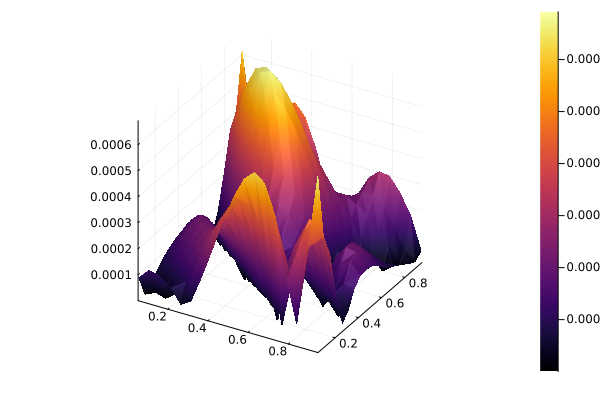

In [6]:
reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

#N_I*2
#cond(Matrix(G))
G = sparse(G)
println(reference_v)
sol = G\Global_RHS
error = abs.(sol - reference_v)
println("max error: ",maximum(error))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I])
#surface(I_points[1,:],I_points[2,:],sol[1:N_I])
surface(I_points[1,:],I_points[2,:],error[1:N_I])

(2, 324)0.052631578947368420.05263157894736842

0.052631578947368420.105263157894736840.052631578947368420.157894736842105250.052631578947368420.210526315789473670.052631578947368420.26315789473684210.052631578947368420.31578947368421050.052631578947368420.36842105263157890.052631578947368420.421052631578947350.052631578947368420.473684210526315760.052631578947368420.52631578947368420.052631578947368420.57894736842105270.052631578947368420.6315789473684210.052631578947368420.68421052631578950.052631578947368420.73684210526315790.052631578947368420.78947368421052630.052631578947368420.84210526315789470.052631578947368420.89473684210526320.052631578947368420.94736842105263150.105263157894736840.052631578947368420.105263157894736840.105263157894736840.105263157894736840.157894736842105250.105263157894736840.210526315789473670.105263157894736840.26315789473684210.105263157894736840.31578947368421050.105263157894736840.36842105263157890.105263157894736840.421052631578947350.105263157894736840.473684210526315760.105263157894736840.5263157

0.36842105263157890.78947368421052630.36842105263157890.84210526315789470.36842105263157890.89473684210526320.36842105263157890.94736842105263150.421052631578947350.052631578947368420.421052631578947350.105263157894736840.421052631578947350.157894736842105250.421052631578947350.210526315789473670.421052631578947350.26315789473684210.421052631578947350.31578947368421050.421052631578947350.36842105263157890.421052631578947350.421052631578947350.421052631578947350.473684210526315760.421052631578947350.52631578947368420.421052631578947350.57894736842105270.421052631578947350.6315789473684210.421052631578947350.68421052631578950.421052631578947350.73684210526315790.421052631578947350.78947368421052630.421052631578947350.84210526315789470.421052631578947350.89473684210526320.421052631578947350.94736842105263150.473684210526315760.052631578947368420.473684210526315760.105263157894736840.473684210526315760.157894736842105250.473684210526315760.210526315789473670.473684210526315760.263157894736

0.89473684210526320.68421052631578950.94736842105263150.73684210526315790.052631578947368420.73684210526315790.105263157894736840.73684210526315790.157894736842105250.73684210526315790.210526315789473670.73684210526315790.26315789473684210.73684210526315790.31578947368421050.73684210526315790.36842105263157890.73684210526315790.421052631578947350.73684210526315790.473684210526315760.73684210526315790.52631578947368420.73684210526315790.57894736842105270.73684210526315790.6315789473684210.73684210526315790.68421052631578950.73684210526315790.73684210526315790.73684210526315790.78947368421052630.73684210526315790.84210526315789470.73684210526315790.89473684210526320.73684210526315790.94736842105263150.78947368421052630.052631578947368420.78947368421052630.105263157894736840.78947368421052630.157894736842105250.78947368421052630.210526315789473670.78947368421052630.26315789473684210.78947368421052630.31578947368421050.78947368421052630.36842105263157890.78947368421052630.42105263157894735

0.9473684210526315

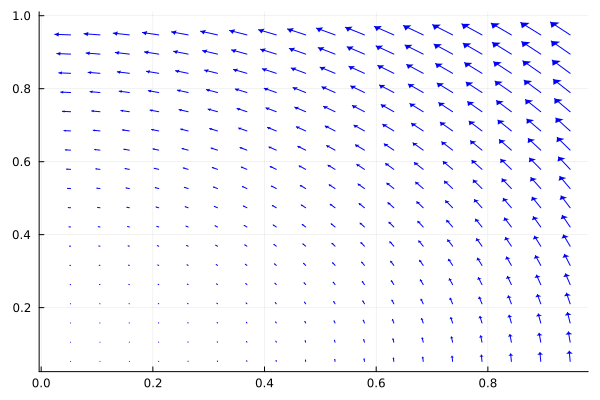

In [7]:
function plot_arrow!(x1,y1,x2,y2)
    color = :blue
    arr_width = 0.2
    vx = x2-x1
    vy = y2 -y1
    l_arr = sqrt(vx*vx+vy*vy)
    pqx= x1+3*(x2-x1)/4
    pqy= y1+3*(y2-y1)/4 # quarterpoint

    vpx = 1
    vpy = -vx/vy
    lp = sqrt(vpx*vpx + vpy*vpy)
    vpx = vpx/lp
    vpy = vpy/lp 

    p1ax = pqx + vpx*l_arr*arr_width
    p1ay = pqy + vpy*l_arr*arr_width

    p2ax = pqx - vpx*l_arr*arr_width
    p2ay = pqy - vpy*l_arr*arr_width

    plot!([x1,x2],[y1,y2],c=color,label = false) # line
    trian = Shape([(p1ax, p1ay),(p2ax,p2ay), (x2,y2), (p1ax, p1ay)])
    plot!(trian, c = color,label = false,linewidth = 0)
end

function visualize_vec_field(Points,u,v)
    scale = 0.05
    vel = sqrt.(u.^2 .+ v .^2)
    mx = maximum(vel)
    print(size(Points))
    plot()
    for i in 1:size(Points)[2]
        px,py = Points[:,i]
        print(px,py)
        #plot!([px,px+scale*u[i]/mx],[py,py+scale*v[i]/mx],label = false,arrow = arrow(),)
        plot_arrow!(px,py,px+scale*u[i]/mx,py+scale*v[i]/mx)
    end
    plot!()
end


visualize_vec_field(I_points,sol[1:N_I],sol[1+N_I:end])